# Activations

## Abstract

In this notebook we discuss tracking of activations of layers by outputs and by parameter gradients. Firstly we analyse binary classification of linearly separable data and then we proceed to examine effect of dropout layers on deep convolutional layer for classification on MNIST dataset. For a much deeper dive see [Neuron Death in ANNs: detecting and troubleshooting](https://ai.gopubby.com/neuron-death-in-anns-detecting-and-troubleshooting-4a7b5cc2f099) by Malcolm Lett.

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

RND_SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Activation Lenses

The whole idea of activation stems from the ReLU and sigmoid activations functions being zero or near-zero for a subset of real numbers. Zeros being multiplicatevily absorbing and additively neutral element does not interact with linear combinations, thus not propagating any information further. Thus a dead neuron is a neuron that does not propagate any information for all of the samples in a training iteration (batch), death rate is a proportion of dead neurons, activation rate is a proportion of outputs activited thorugh a dataset pass. This idea is represented by ``OutputActivation`` lens, on every forward pass through a layer outputs are put to be either active or inactive; death and activation rates are then calculated.

``OutputNorm`` records data for all activations functions and dropout by default. Its behavious can be configured by ``activation``, ``dropout``, ``include`` and ``exclude`` flags.

If neuron is dead, i.e., its outputs are constant, it will have a zero gradient; therefore both activation and death rate can be reconstructed from gradients with respect to neuron's parameters. This idea is implemented in ``ParameterGradientActivation`` lens. Note that it does not hook onto a module, but on parameter tensors, and PyTorch allows to hook only onto non-lazy tensors, hence lazy modules' gradients (such as ``nn.LazyLinear``) cannot be tracked by this lens.

``ParameterGradientActivation`` records data for all layer that have all of the parameters listed in ``parameters`` initialization arguments, default are ``"weight"`` and ``"bias"``.

Both plots allow for warning plot that plots minimal activation rate and maximal death rate accross all layers (and parameters).

Let us 

In [3]:
from monitorch.inspector import PyTorchInspector
from monitorch.lens import LossMetrics, OutputActivation, ParameterGradientActivation

loss_fn = nn.CrossEntropyLoss()

inspector = PyTorchInspector(
    lenses = [
        LossMetrics(
            loss_fn=loss_fn,
            separate_loss_and_metrics=False,
            metrics=['val_accuracy']
        ),
        OutputActivation(),
        ParameterGradientActivation()
    ]
)

In [4]:
def train_one_epoch(model, loss_fn, optimizer, train_dataloader, device=device):
    """ Trains model through dataset one time. """
    for data, label in train_dataloader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        pred = model(data)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()

@torch.no_grad
def validate_one_epoch(model, loss_fn, val_dataloader, device=device):
    """ Validates through given dataset. """
    correctly_classified = 0
    n_samples = 0
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)
        pred = model(data)
        loss = loss_fn(pred, label)
        n_samples += data.shape[0]
        correctly_classified += pred.argmax(dim=1).eq(label).float().sum().item()
    return correctly_classified / n_samples

## 2D Examples

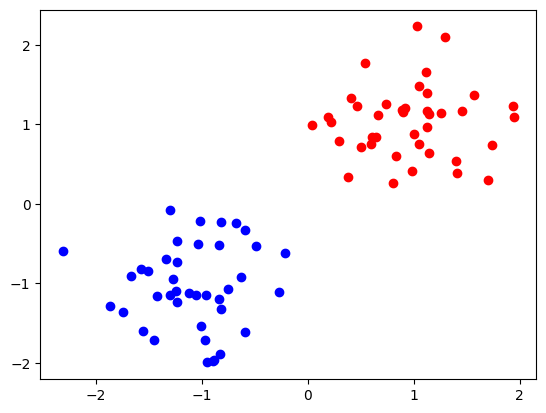

In [5]:
def plot_decision_boundary(model, X, y, ax=None, resolution=0.02):
    """
    Plots decision boundary for a binary classifier.
    model: trained PyTorch model
    X: torch.Tensor or np.ndarray of shape (N, 2)
    y: torch.Tensor or np.ndarray of shape (N,) or (N,1)
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Convert tensors to numpy if needed
    if torch.is_tensor(X):
        X = X.detach().cpu().numpy()
    if torch.is_tensor(y):
        y = y.detach().cpu().numpy()

    # Determine grid range
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Prepare grid for prediction
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Get predictions
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)[:, 1].cpu().numpy()
        Z = (preds > 0.5).astype(int)               # binary mask

    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)

    # Plot original points
    ax.scatter(X[y==1, 0], X[y==1, 1], c='b', edgecolor='k', label="Positive")
    ax.scatter(X[y==0, 0], X[y==0, 1], c='r', edgecolor='k', label="Negative")

    ax.legend()
    ax.set_title("Decision Boundary")
    plt.show()

def make_dataloaders(pos, neg):
    X = np.vstack((pos, neg))
    y = np.hstack((np.ones(len(pos)), np.zeros(len(neg))))
    
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    
    full_dataset = TensorDataset(X_tensor, y_tensor)
    
    # Split into train and validation (e.g., 70% train / 30% val)
    train_size = int(0.7 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size],
                                              generator=torch.Generator().manual_seed(RND_SEED))
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    return train_loader, val_loader

np.random.seed(RND_SEED)
pos = np.random.standard_normal(size=(40, 2))*0.5 -1
neg = np.random.standard_normal(size=(40, 2))*0.5 +1
X = np.vstack((pos, neg))
y = np.hstack((np.ones(len(pos)), np.zeros(len(neg))))
plt.scatter(pos[:, 0], pos[:, 1], color='b')
plt.scatter(neg[:, 0], neg[:, 1], color='r')
train_lin_loader, validate_lin_loader = make_dataloaders(pos, neg)


lin separable case

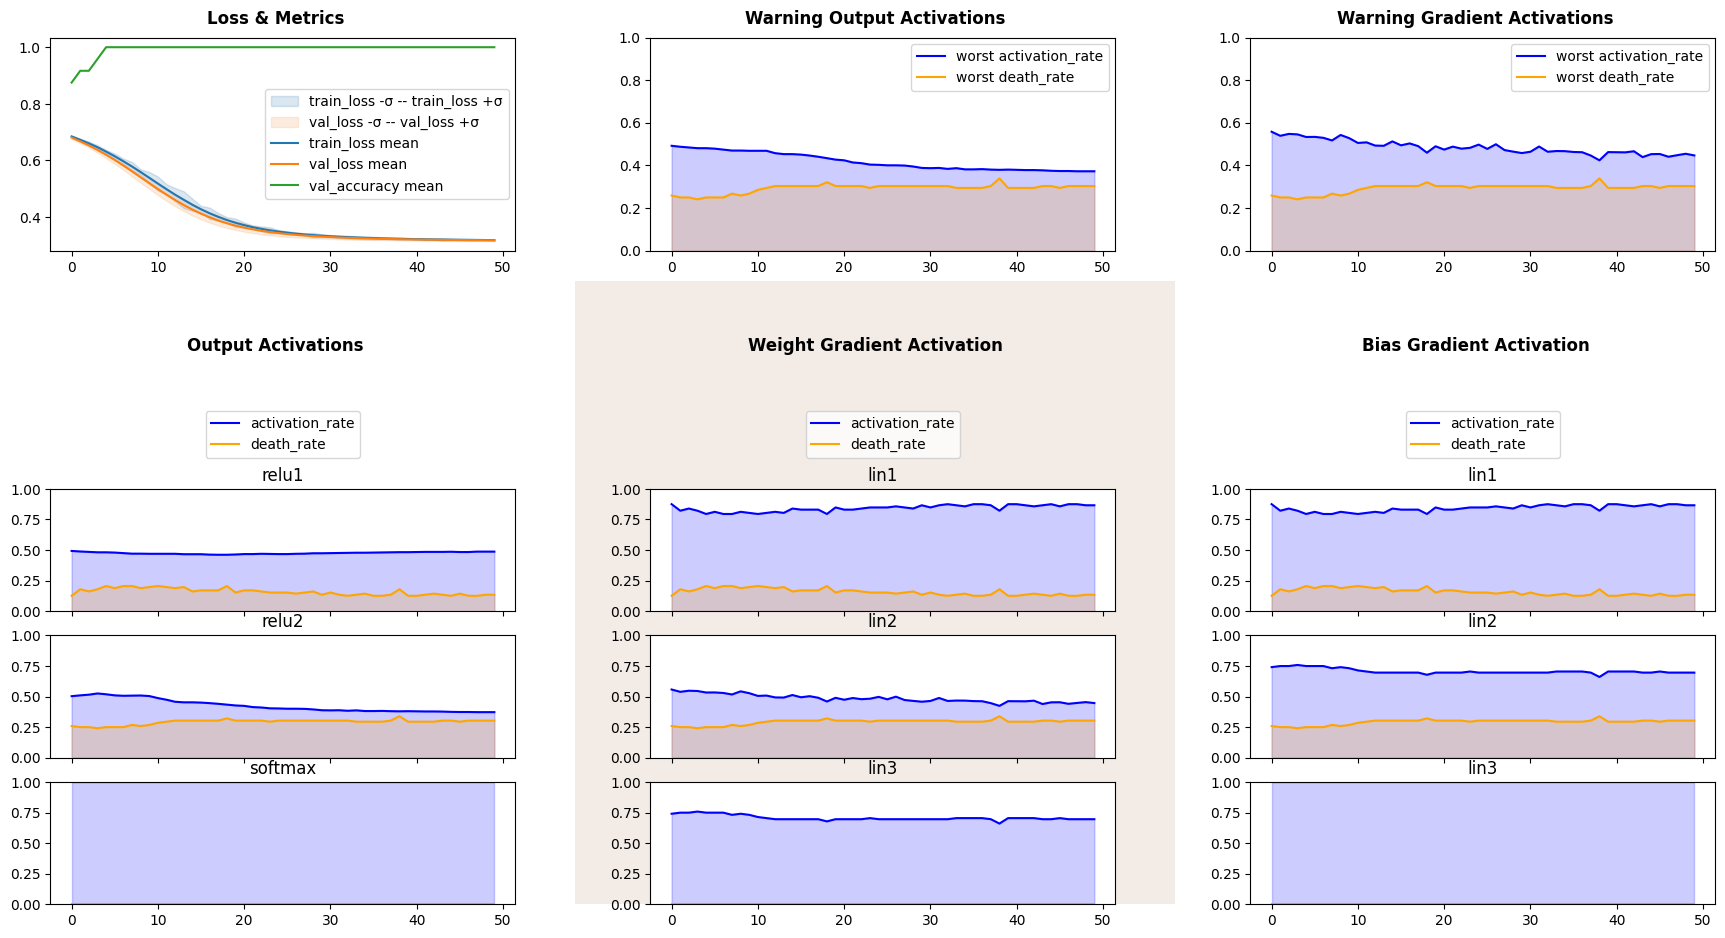

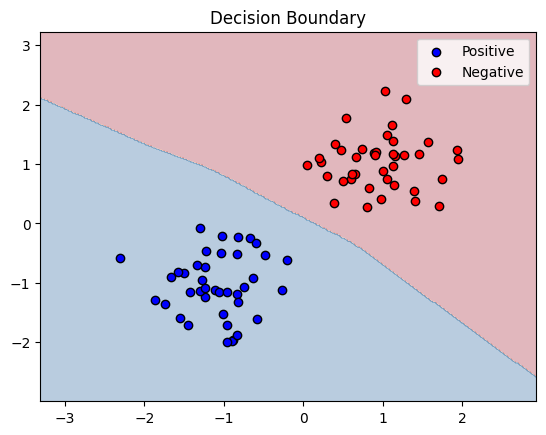

In [6]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
    ('lin1', nn.Linear(2, 16)),
    ('relu1', nn.ReLU()),

    ('lin2', nn.Linear(16, 16)),
    ('relu2', nn.ReLU()),
    
    ('lin3', nn.Linear(16, 2)),
    ('softmax', nn.Softmax(dim=1))
])).to(device)
inspector.attach(model)
optimizer = torch.optim.Adam(model.parameters())

N_EPOCH = 50
for epoch in range(N_EPOCH):
    train_one_epoch(model, loss_fn, optimizer, train_lin_loader)
    val_acc = validate_one_epoch(model, loss_fn, validate_lin_loader)
    inspector.push_metric('val_accuracy', val_acc)
    inspector.tick_epoch()

fig = inspector.visualizer.show_fig()
plot_decision_boundary(model.cpu(), X, y)

## MNIST

In [7]:
from monitorch.inspector import PyTorchInspector
from monitorch.lens import LossMetrics, OutputActivation, ParameterGradientActivation

loss_fn = nn.CrossEntropyLoss()

inspector = PyTorchInspector(
    lenses = [
        LossMetrics(
            loss_fn=loss_fn,
            separate_loss_and_metrics=False,
            metrics=['val_accuracy']
        ),
        OutputActivation(),
        ParameterGradientActivation()
    ]
)

In [8]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])

trainset = MNIST(
    './data',
    download=True,
    train=True,
    transform=transform
)

testset = MNIST(
    './data',
    download=True,
    train=False,
    transform=transform
)
BATCH_SIZE = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

validateloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.47MB/s]


In [9]:
class CNN(nn.Module):

    def __init__(self, dropout=(0, 0, 0)):
        super().__init__()
        self.conv = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 64, kernel_size=7, padding='same')),
            ('pool1', nn.MaxPool2d(kernel_size=7)),
            ('relu1', nn.ReLU()),

            ('dropout', nn.Dropout(dropout[0])),

            ('conv2', nn.Conv2d(64, 128, kernel_size=4)),
            ('relu2', nn.ReLU()),
        ]))

        self.dense = nn.Sequential(OrderedDict([
            ('dropout1', nn.Dropout(dropout[1])),
            ('lin1',  nn.Linear(128, 32)),
            ('relu1', nn.ReLU()),
            
            ('dropout2', nn.Dropout(dropout[2])),
            ('lin2',    nn.Linear(32, 10)),
            ('softmax', nn.Softmax(dim=1))
        ]))

    def forward(self, X):
        t = torch.flatten(self.conv(X), start_dim=1)
        return self.dense(t)

In [10]:
class EarlyStopper:
    def __init__(self, patience : int = 5, eps : float = 1e-3):
        self.loss = float('+inf')
        self.timer = 0
        self.eps = eps
        self.patience = patience

    def __call__(self, new_loss : float) -> bool:
        if self.loss - new_loss > self.eps:
            self.loss = new_loss
            self.timer = 0
            return False
        self.timer += 1
        return self.timer >= self.patience

 44%|████▍     | 22/50 [04:06<05:13, 11.20s/it]


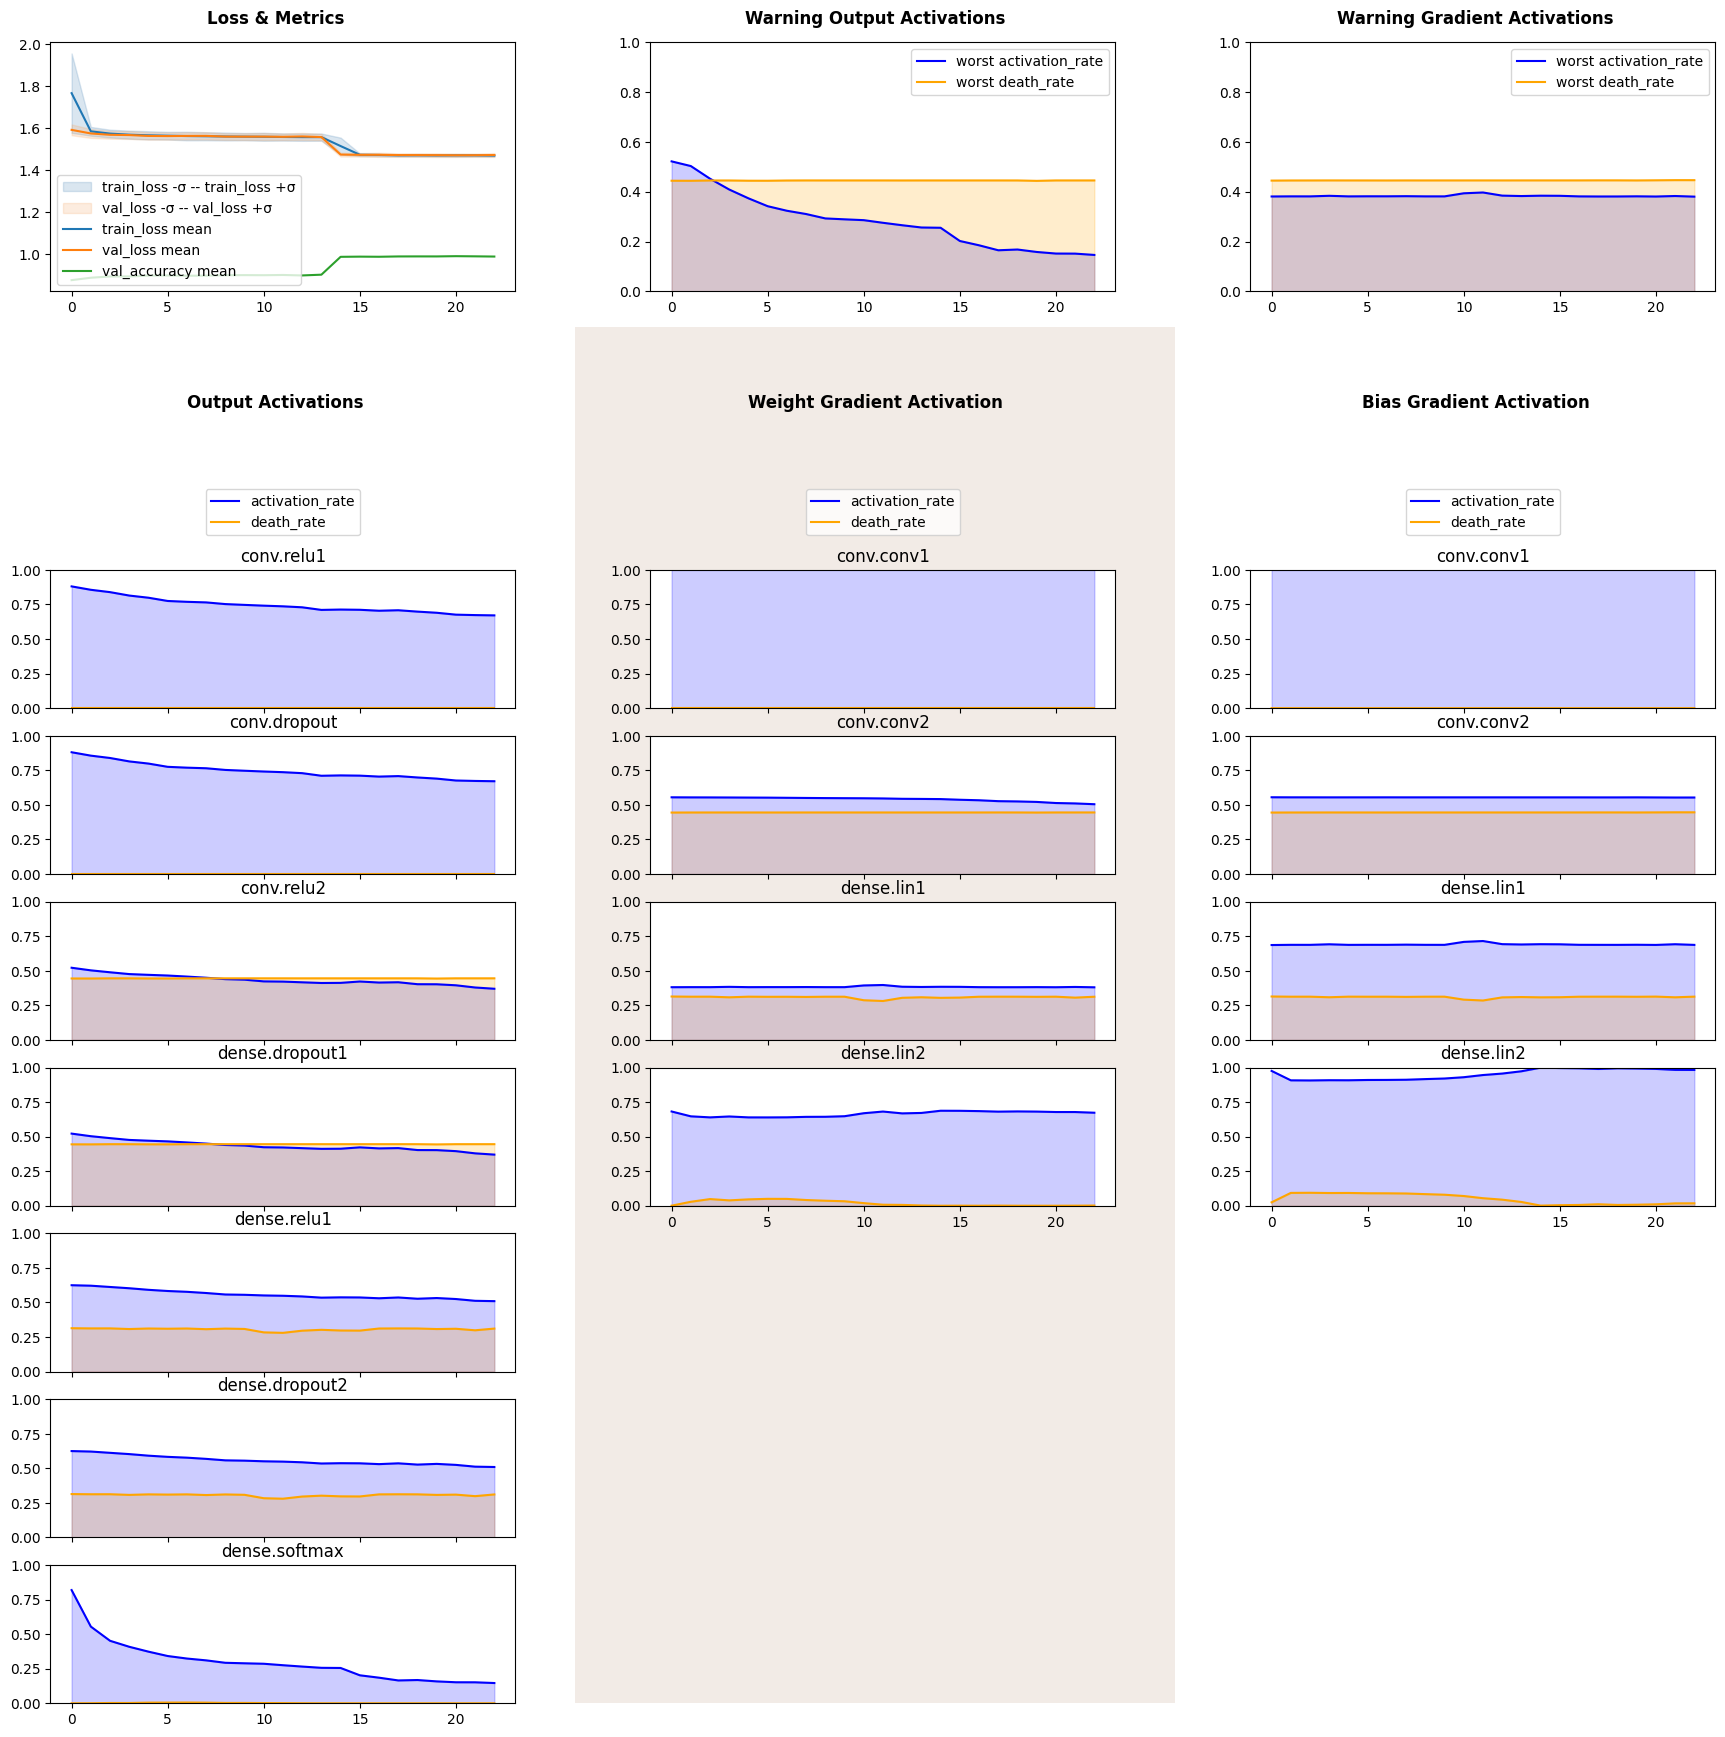

In [11]:
from tqdm import trange
model = CNN().to(device)

stopper = EarlyStopper()
inspector.attach(model)
optimizer = torch.optim.Adam(model.parameters())

N_EPOCH = 50
for epoch in trange(N_EPOCH):
    train_one_epoch(model, loss_fn, optimizer, trainloader)
    val_acc = validate_one_epoch(model, loss_fn, validateloader)
    inspector.push_metric('val_accuracy', val_acc)
    inspector.tick_epoch()
    if stopper(inspector.lenses[0].loss(train=False)):
        break

fig = inspector.visualizer.show_fig()

 52%|█████▏    | 26/50 [04:44<04:22, 10.94s/it]


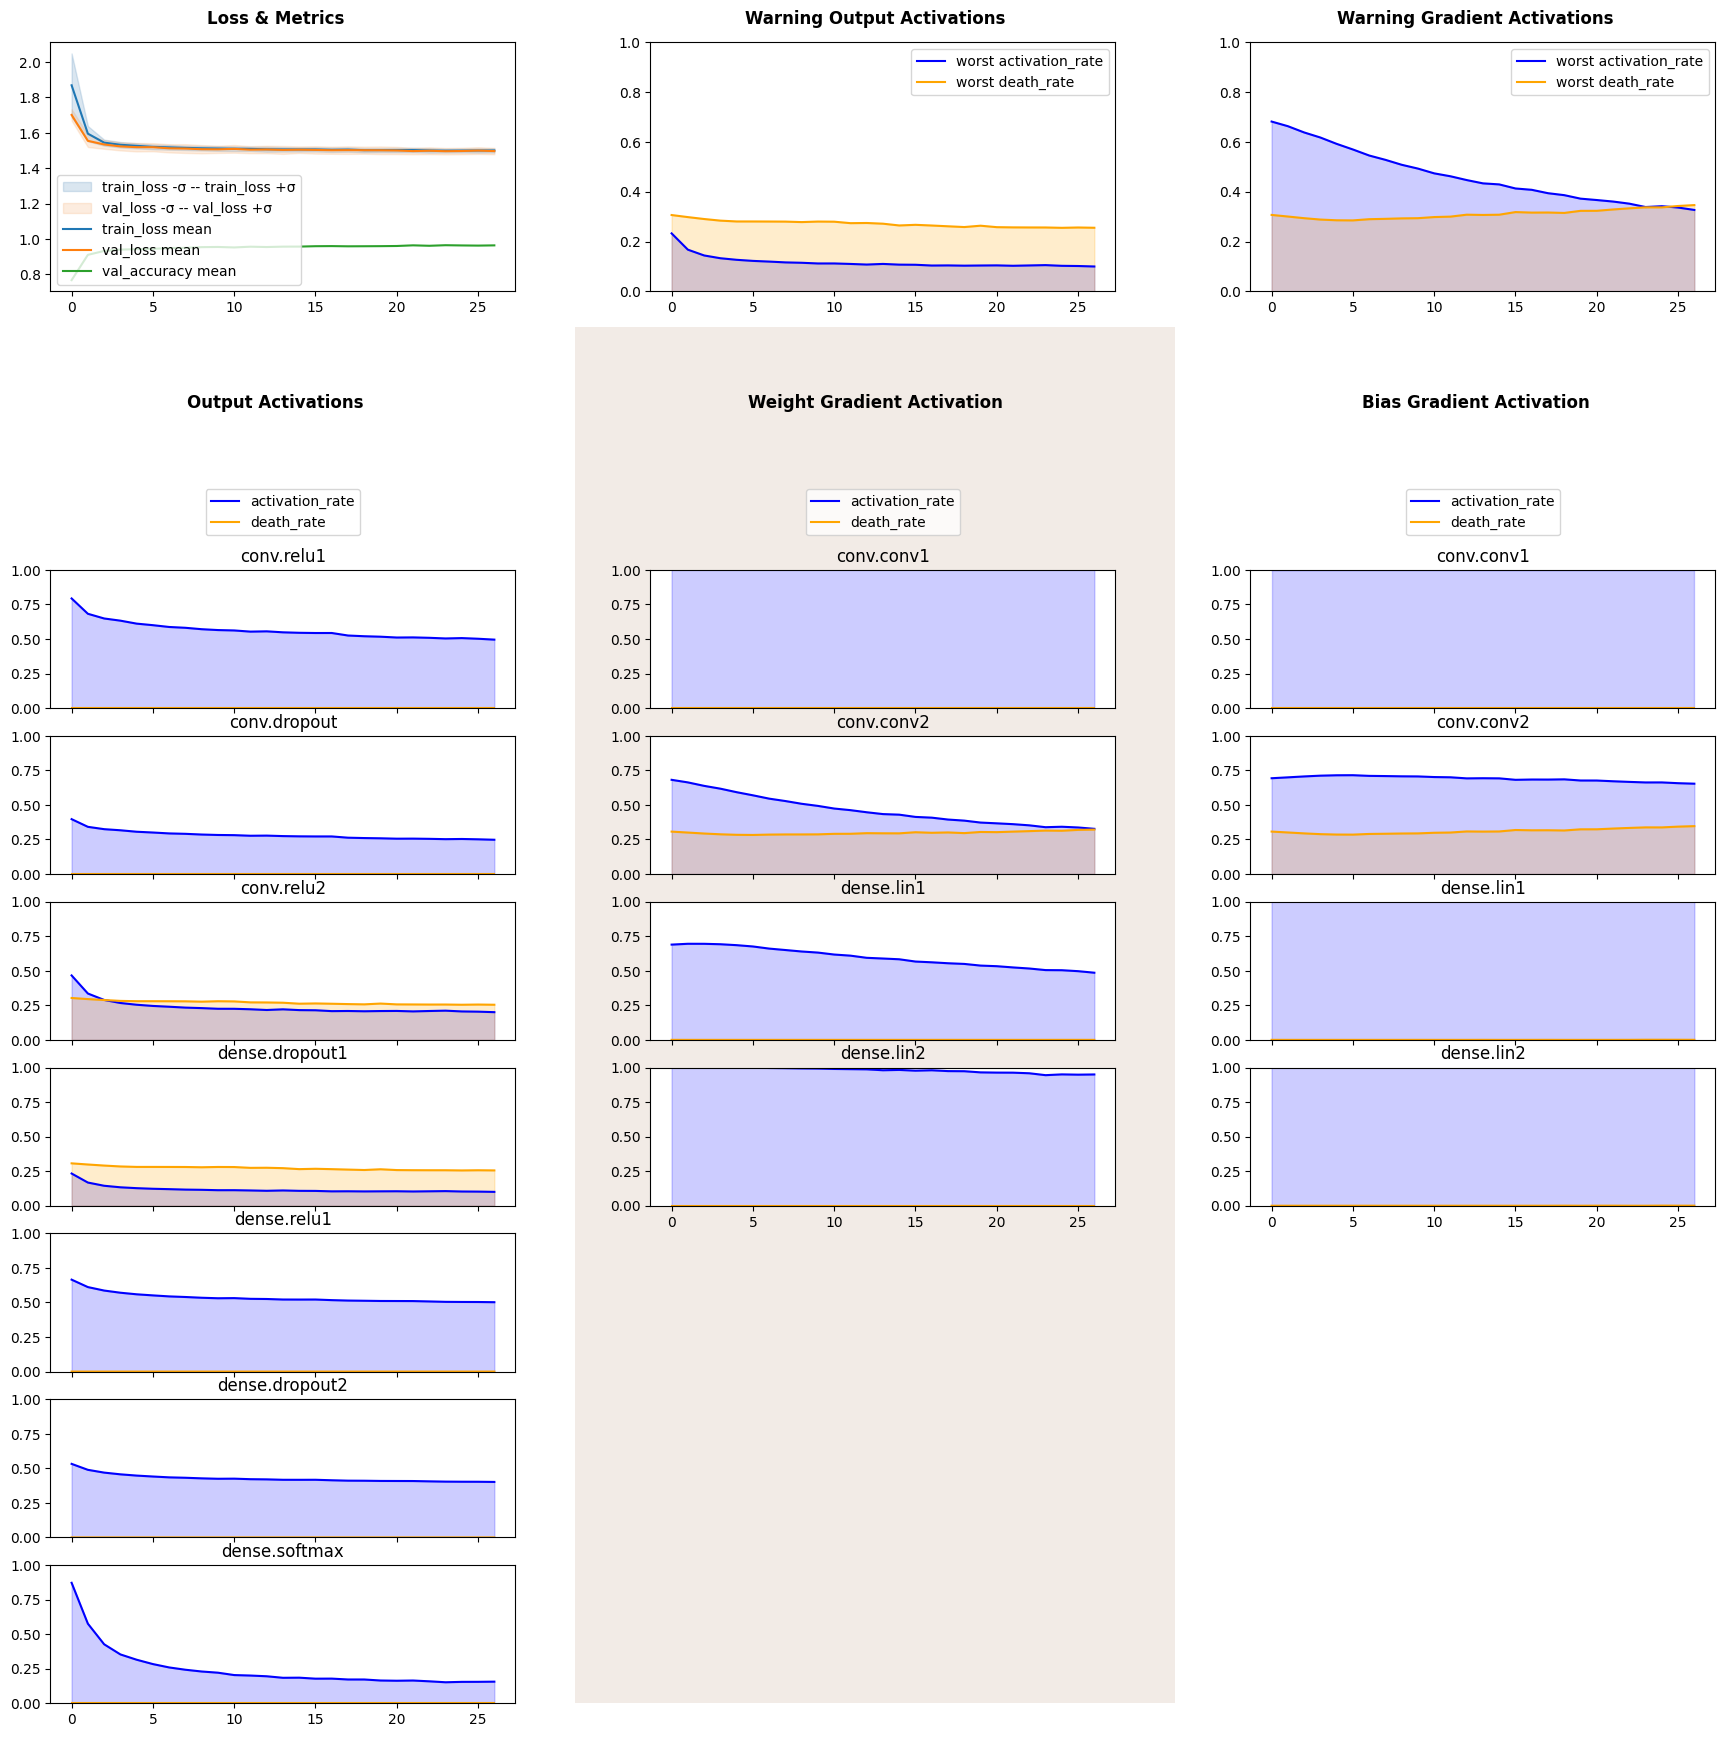

In [12]:
from tqdm import trange
model = CNN(dropout=(0.5, 0.5, 0.2)).to(device)

stopper = EarlyStopper()
inspector.attach(model)
optimizer = torch.optim.Adam(model.parameters())

N_EPOCH = 50
for epoch in trange(N_EPOCH):
    train_one_epoch(model, loss_fn, optimizer, trainloader)
    val_acc = validate_one_epoch(model, loss_fn, validateloader)
    inspector.push_metric('val_accuracy', val_acc)
    inspector.tick_epoch()
    if stopper(inspector.lenses[0].loss(train=False)):
        break

fig = inspector.visualizer.show_fig()

## What to Look for

## Next Steps